Version: 0.0.2  Updated date: 07/05/2024
Conda Environment : py-snowpark_df_ml_fs-1.15.0_v1

# Getting Started with Snowflake Feature Store
We will use the Use-Case to show how Snowflake Feature Store (and Model Registry) can be used to maintain & store features, retrieve them for training and perform micro-batch inference.

In the development (TRAINING) enviroment we will 
- create FeatureViews in the Feature Store that maintain the required customer-behaviour features.
- use these Features to train a model, and save the model in the Snowflake model-registry.
- plot the clusters for the trained model to visually verify. 

In the production (SERVING) environment we will
- re-create the FeatureViews on production data
- generate an Inference FeatureView that uses the saved model to perform incremental inference

# Feature Engineering & Model Training

In [1]:
%load_ext autoreload
%autoreload 2

#### Notebook Packages

In [2]:
# Python packages
import os
import json
import timeit

# SNOWFLAKE
# Snowpark
from snowflake.snowpark import Session, DataFrame, Window, WindowSpec, Row
from feature_engineering_fns import uc01_load_data, uc01_pre_process_v2
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

# Snowflake Feature Store
from snowflake.ml.feature_store import (
    FeatureView,
    Entity)

# COMMON FUNCTIONS
from useful_fns import check_and_update, dataset_check_and_update, create_ModelRegistry, create_FeatureStore, create_SF_Session, get_spine_df

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup Snowflake connection and database parameters

In [3]:
# Schemas
tpcxai_training_schema     = 'TRAINING'

In [4]:
fs_qs_role, tpcxai_database, tpcxai_training_schema, session, warehouse_env = create_SF_Session(tpcxai_training_schema, role="ACCOUNTADMIN")

You might have more than one threads sharing the Session object trying to update sql_simplifier_enabled. Updating this while other tasks are running can potentially cause unexpected behavior. Please update the session configuration before starting the threads.



Connection Established with the following parameters:
User                        : JARCHEN
Role                        : "ACCOUNTADMIN"
Database                    : "TPCXAI_SF0001_QUICKSTART_INC"
Schema                      : "TRAINING"
Warehouse                   : "TPCXAI_SF0001_QUICKSTART_WH"
Snowflake version           : 9.37.1
Snowpark for Python version : 1.38.0 



## MODEL DEVELOPMENT
* Create Snowflake Model-Registry
* Create Snowflake Feature-Store
* Establish and Create CUSTOMER Entity in the development Snowflake FeatureStore
* Create Source Data references and perform basic data-cleansing
* Create & Run Preprocessing Function to create features
* Create FeatureView_Preprocess from Preprocess Dataframe SQL
* Create training data from FeatureView_Preprocess (asof join)
* Create & Fit Snowpark-ml pipeline 
* Save model in Model Registry
* 'Verify' and approve model
* Create new FeatureView_Model_Inference with Transforms UDF + KMeans model

In [5]:
# Set the Schema
tpcxai_schema = tpcxai_training_schema

# Create/Reference Snowflake Model Registry - Common across Environments
mr = create_ModelRegistry(session, tpcxai_database, 'MODEL_1')

# Create/Reference Snowflake Feature Store for Training (Development) Environment
fs = create_FeatureStore(session, tpcxai_database, f'''_{tpcxai_schema}_FEATURE_STORE''', warehouse_env)


Model Registry (MODEL_1) already exists
Feature Store (_TRAINING_FEATURE_STORE) already exists


In [6]:
from snowflake.ml.dataset import Dataset
ds = Dataset.load(session=session, name='TPCXAI_SF0001_QUICKSTART_INC._TRAINING_FEATURE_STORE.UC01_TRAINING')
ds.fully_qualified_name, ds.list_versions()

('TPCXAI_SF0001_QUICKSTART_INC._TRAINING_FEATURE_STORE.UC01_TRAINING',
 ['2025_11_20_23_43_54', '2025_11_20_23_47_01', '2025_11_21_16_52_56', 'V_1'])

In [7]:
from snowflake.ml.dataset import load_dataset
training_dataset_sdf_v1 = load_dataset(session, 'TPCXAI_SF0001_QUICKSTART_INC._TRAINING_FEATURE_STORE.UC01_TRAINING', 'V_1')
training_dataset_sdf_v1 = training_dataset_sdf_v1.read.to_snowpark_dataframe()

In [8]:
# Display some sample data
training_dataset_sdf_v1.sort('O_CUSTOMER_SK').show(5)

------------------------------------------------------------------------------------------------------
|"O_CUSTOMER_SK"  |"ASOF_DATE"  |"COL_1"  |"FREQUENCY"         |"RETURN_RATIO"  |"RETURN_ROW_PRICE"  |
------------------------------------------------------------------------------------------------------
|0                |2024-08-02   |values1  |1.6670000553131104  |1.0             |69.0                |
|1                |2024-05-02   |values1  |2.3329999446868896  |1.0             |39.0                |
|2                |2024-05-24   |values1  |1.6670000553131104  |1.0             |27.0                |
|3                |2024-07-18   |values1  |3.0                 |1.0             |65.0                |
|4                |2024-02-23   |values1  |2.3329999446868896  |1.0             |12.0                |
------------------------------------------------------------------------------------------------------



In [9]:
training_dataset_sdf_v1.to_pandas().head()

,O_CUSTOMER_SK,ASOF_DATE,COL_1,FREQUENCY,RETURN_RATIO,RETURN_ROW_PRICE
0,28623,2024-07-27,values1,5.000,1.0,34.0
1,24706,2024-03-21,values1,1.500,1.0,100.0
2,22643,2024-04-19,values1,2.000,1.0,12.0
3,54861,2024-03-22,values1,1.667,1.0,38.0
4,58841,2024-01-18,values1,2.000,1.0,25.0


### Fit Snowpark-ML Transforms & Model using Fileset training data

We need to fit the transformer over the training Fileset to ensure we are using the same input global values for transforming and training, and later inference with the model.

The transforms here are model-specific and persisted within the model-pipeline, and not stored in the Feature Store.

In [10]:
def train_test_split(training_dataset_sdf):
    weights = [0.6, 0.4]
    training_dataset_sdf = training_dataset_sdf.with_column("FREQUENCY", F.round(F.col("FREQUENCY"), 3))
    training_dataset_sdf = training_dataset_sdf.with_column("RETURN_RATIO", F.round(F.col("RETURN_RATIO"), 3))
    training_dataset_sdf = training_dataset_sdf.with_column("RETURN_ROW_PRICE", F.round(F.col("RETURN_ROW_PRICE"), 3))
    training_dataset_sdf = training_dataset_sdf.select(['RETURN_RATIO', 'FREQUENCY', 'RETURN_ROW_PRICE'])

    train_df, test_df = training_dataset_sdf.random_split(weights, seed=42) # Using a seed for reproducibility
    return train_df, test_df

In [15]:
#### Use-Case 01 - Specific Packages
# from sklearn.pipeline import Pipeline as sml_Pipeline
from snowflake.ml.modeling.pipeline.pipeline import Pipeline as sml_Pipeline
# from sklearn.preprocessing import MinMaxScaler as sml_MinMaxScaler
from snowflake.ml.modeling.preprocessing.min_max_scaler import MinMaxScaler as sml_MinMaxScaler
# from sklearn.compose import ColumnTransformer as sml_ColumnTransformer
from snowflake.ml.modeling.compose.column_transformer import ColumnTransformer as sml_ColumnTransformer

# from xgboost import XGBRegressor
from snowflake.ml.modeling.xgboost.xgb_regressor import XGBRegressor as sml_XGBRegressor
import pandas as pd
from snowflake.snowpark.dataframe import DataFrame
def uc01_train(featurevector: DataFrame, n_estimators=100):
    feature_cols = ['RETURN_RATIO', 'FREQUENCY'] 
    mms_output_cols = ['RETURN_RATIO', 'FREQUENCY', 'RETURN_ROW_PRICE']
       
    target_col = "RETURN_ROW_PRICE"

    # Create preprocessing steps
    preprocessor = sml_ColumnTransformer(
        transformers=[
            ('NUM', sml_MinMaxScaler(), feature_cols)
        ],
        remainder='passthrough',
        output_cols=mms_output_cols
    )

    # Create pipeline
    pipeline = sml_Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', sml_XGBRegressor(
                random_state=42,
                n_estimators=n_estimators,
                input_cols=feature_cols,
                label_cols=[target_col],
                output_cols=['PREDICTION']
            )
        )
    ])

    model = pipeline.fit(featurevector)
    return model

In [16]:
#### Use-Case 01 - Specific Packages
from sklearn.pipeline import Pipeline as sk_Pipeline
from sklearn.preprocessing import MinMaxScaler as sk_MinMaxScaler
from sklearn.compose import ColumnTransformer as sk_ColumnTransformer
from xgboost import XGBRegressor
import pandas as pd

def uc01_train_sklearn(featurevector: pd.DataFrame, n_estimators=100):
    feature_cols = ['RETURN_RATIO', 'FREQUENCY'] 
    mms_output_cols = ['RETURN_RATIO', 'FREQUENCY', 'RETURN_ROW_PRICE']
       
    target_col = "RETURN_ROW_PRICE"

    # Create preprocessing steps
    preprocessor = sk_ColumnTransformer(
        transformers=[
            ('NUM', sk_MinMaxScaler(), feature_cols)
        ],
        remainder='passthrough'
    )

    # Create pipeline
    pipeline = sk_Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
                random_state=42,
                n_estimators=n_estimators
            )
        )
    ])

    X = featurevector[feature_cols]
    y = featurevector[[target_col]]
    model = pipeline.fit(X, y)
    return model

In [17]:
## Fit the Model
model_name = "MODEL_1.UC01_SNOWFLAKEML_RF_REGRESSOR_MODEL"
train_df, test_df = train_test_split(training_dataset_sdf_v1)
train_pd_df = train_df.to_pandas()

In [18]:
train_result = uc01_train(train_df)
train_sklern_result = uc01_train_sklearn(train_pd_df)

# Check for the latest version of this model in registry, and increment version
mr_df = mr.show_models()
model_version = check_and_update(mr_df, model_name)
print('model version:\t',model_version)

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42064 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42064 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42064 rows. Using the first 100 rows to define the inputs and outputs of 

model version:	 WICKED_CHICKEN_10


In [25]:
sample = train_df.limit(10)
sample_pd = train_pd_df.head(10)

In [23]:
# Save the Model to the Model Registry
model_base = mr.log_model(
    model= train_result,
    model_name= model_name,
    comment="TPCXAI USE CASE 01 - XGB Regressor",
    sample_input_data=sample,
    # options= {
    #     "enable_explainability": True,
    #     "method_options": {"predict": {"case_sensitive": True}, "explain": {"case_sensitive": True}}
    # }
)

Logging model: creating model manifest...:  33%|███▎      | 2/6 [00:02<00:05,  1.25s/it]  

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/registry/_manager/model_parameter_reconciler.py:72: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  reconciled_options = self._reconcile_relax_version(reconciled_options, reconciled_target_platforms)
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/_packager/model_packager.py:90: UserWarning: Providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(


<snowflake.ml.modeling.compose.column_transformer.ColumnTransformer object at 0x31f528f10> preprocessor
Model logged successfully.: 100%|██████████| 6/6 [00:26<00:00,  4.42s/it]                          


In [29]:
# Save the Model to the Model Registry
model_sklearn = mr.log_model(
    model= train_sklern_result,
    model_name= model_name + "sklearn",
    comment="TPCXAI USE CASE 01 - XGB Regressor",
    sample_input_data=sample_pd[['RETURN_RATIO', 'FREQUENCY']],
    options= {
        "enable_explainability": True,
    }
)

Logging model: creating model manifest...:  33%|███▎      | 2/6 [00:00<00:00,  4.26it/s]  

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/registry/_manager/model_parameter_reconciler.py:72: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  reconciled_options = self._reconcile_relax_version(reconciled_options, reconciled_target_platforms)
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 10 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(


Model logged successfully.: 100%|██████████| 6/6 [00:20<00:00,  3.44s/it]                          


In [ ]:
# Get and set default for latest version of the model
m = mr.get_model(model_name)
latest_version = m.show_versions().iloc[-1]['name']
mv = m.version(latest_version)
m.default = latest_version

## We noticed the feature wasn't correct

In [ ]:
order_tbl = '.'.join([tpcxai_database, tpcxai_schema,'ORDERS'])
order_sdf = session.table(order_tbl)
customer_entity = fs.get_entity("ORDER")
# Tables
line_item_tbl            = '.'.join([tpcxai_database, tpcxai_schema,'LINEITEM'])
order_returns_tbl        = '.'.join([tpcxai_database, tpcxai_schema,'ORDER_RETURNS'])
# Snowpark Dataframe
line_item_sdf            = session.table(line_item_tbl)
order_returns_sdf        = session.table(order_returns_tbl)
raw_data = uc01_load_data(order_sdf, line_item_sdf, order_returns_sdf)

In [ ]:
def generate_training_df(spine_sdf, feature_view):
    dataset_name = 'UC01_TRAINING_V2'
    dataset_version = dataset_check_and_update(session, dataset_name)
    # Generate_Dataset
    training_dataset = fs.generate_dataset( 
        name = dataset_name,
        version = dataset_version,
        spine_df = spine_sdf, 
        features = [feature_view], 
        spine_timestamp_col = 'ASOF_DATE'
        )                                     
    # Create a snowpark dataframe reference from the Dataset
    training_dataset_sdf = training_dataset.read.to_snowpark_dataframe()
    
    return training_dataset_sdf

In [ ]:
preprocessed_data_v2 = uc01_pre_process_v2(raw_data)
ppd_fv_name    = "FV_UC01_PREPROCESS"
ppd_fv_version = "V_2"
# Define descriptions for the FeatureView's Features.  These will be added as comments to the database object
preprocess_features_desc = {  "FREQUENCY":"Average yearly order frequency",
                              "RETURN_RATIO":"Average of, Per Order Returns Ratio.  Per order returns ratio : total returns value / total order value" }

# Create the FeatureView instance
fv_uc01_preprocess_instance = FeatureView(
    name=ppd_fv_name, 
    entities=[customer_entity], 
    feature_df=preprocessed_data_v2,      # <- We can use the snowpark dataframe as-is from our Python
    # feature_df=preprocessed_data_v2.queries['queries'][0],    # <- Or we can use SQL, in this case linted from the dataframe generated SQL to make more human readable
    timestamp_col="LATEST_ORDER_DATE",
    refresh_freq="60 minute",            # <- specifying optional refresh_freq creates FeatureView as Dynamic Table, else created as View.
    desc="Features to support Use Case 01").attach_feature_desc(preprocess_features_desc)

# Register the FeatureView instance.  Creates  object in Snowflake
fv_uc01_preprocess_v2 = fs.register_feature_view(
    feature_view=fv_uc01_preprocess_instance, 
    version=ppd_fv_version, 
    block=True,     # whether function call blocks until initial data is available
    overwrite=False # whether to replace existing feature view with same name/version
)
spine_sdf = get_spine_df(fv_uc01_preprocess_v2)
training_dataset_sdf_v2 = generate_training_df(spine_sdf, fv_uc01_preprocess_v2)

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/feature_store/feature_store.py:555: UserWarning: FeatureView FV_UC01_PREPROCESS/V_2 already exists. Skip registration. Set `overwrite` to True if you want to replace existing FeatureView.
  return self._get_feature_view_if_exists(feature_view.name, str(version))


In [ ]:
## Fit the Model
model_name = "MODEL_1.UC01_SNOWFLAKEML_XGB_REGRESSOR_MODEL_V2"
train_df_v2, test_df_v2 = train_test_split(training_dataset_sdf_v2)
train_result = uc01_train(train_df_v2)

# Check for the latest version of this model in registry, and increment version
mr_df = mr.show_models()
model_version = check_and_update(mr_df, model_name)
print('model version:\t',model_version)
# Save the Model to the Model Registry
sample = train_df.to_pandas().head(10)
# Save the Model to the Model Registry
mv_kmeans = mr.log_model(
    model= train_result,
    model_name= model_name,
    version_name= model_version,
    comment="TPCXAI USE CASE 01 - XGB Regressor",
    sample_input_data=sample,
    options= {
        # "enable_explainability": True
    }
)
# Get and set default for latest version of the model
m = mr.get_model(model_name)
latest_version = m.show_versions().iloc[-1]['name']
mv = m.version(latest_version)
m.default = latest_version

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of 

['V_1', 'V_1', 'V_1', 'V_2', 'V_3', 'V_4'] V_4
model version:	 V_5
Logging model: creating model manifest...:  33%|███▎      | 2/6 [00:00<00:00,  4.81it/s]  

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/registry/_manager/model_parameter_reconciler.py:72: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  reconciled_options = self._reconcile_relax_version(reconciled_options, reconciled_target_platforms)
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/_packager/model_packager.py:90: UserWarning: Providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 10 rows. Using the first 100 rows to

Model logged successfully.: 100%|██████████| 6/6 [00:21<00:00,  3.65s/it]                          


In [ ]:
model_name = "MODEL_1.UC01_SNOWFLAKEML_XGB_REGRESSOR_MODEL_V2"
train_result = uc01_train(train_df_v2, n_estimators = 110)
# Check for the latest version of this model in registry, and increment version
mr_df = mr.show_models()
model_version = check_and_update(mr_df, model_name)
print('model version:\t',model_version)
# Save the Model to the Model Registry
sample = train_df.to_pandas().head(10)
# Save the Model to the Model Registry
mv_kmeans = mr.log_model(
    model= train_result,
    model_name= model_name,
    version_name= model_version,
    comment="TPCXAI USE CASE 01 - XGB Regressor",
    sample_input_data=sample,
    options= {
        # "enable_explainability": True
    }
)
# Get and set default for latest version of the model
m = mr.get_model(model_name)
latest_version = m.show_versions().iloc[-1]['name']
mv = m.version(latest_version)
m.default = latest_version

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of 

['V_1', 'V_1', 'V_1', 'V_2', 'V_3', 'V_4', 'V_5'] V_5
model version:	 V_6
Logging model: creating model manifest...:  33%|███▎      | 2/6 [00:00<00:00,  4.91it/s]  

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/registry/_manager/model_parameter_reconciler.py:72: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  reconciled_options = self._reconcile_relax_version(reconciled_options, reconciled_target_platforms)
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/_packager/model_packager.py:90: UserWarning: Providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 10 rows. Using the first 100 rows to

Model logged successfully.: 100%|██████████| 6/6 [00:16<00:00,  2.71s/it]                          


In [ ]:
# Generate_Dataset
training_set_sdf = fs.generate_training_set(
                                        spine_df = spine_sdf, 
                                        features = [fv_uc01_preprocess_v2], 
                                        spine_timestamp_col = 'ASOF_DATE'
                                        )                                     
# Display some sample data
training_set_sdf.sort('O_CUSTOMER_SK').show(5)

-----------------------------------------------------------------------------------------------
|"O_CUSTOMER_SK"  |"ASOF_DATE"  |"COL_1"  |"FREQUENCY"  |"RETURN_RATIO"  |"RETURN_ROW_PRICE"  |
-----------------------------------------------------------------------------------------------
|0                |2024-08-02   |values1  |1.667        |1.000           |69.000              |
|1                |2024-05-02   |values1  |2.333        |1.000           |39.000              |
|2                |2024-05-24   |values1  |1.667        |1.000           |27.000              |
|3                |2024-07-18   |values1  |3.000        |1.000           |65.000              |
|4                |2024-02-23   |values1  |2.333        |1.000           |12.000              |
-----------------------------------------------------------------------------------------------



In [ ]:
mr.show_models()


,created_on,name,model_type,database_name,schema_name,comment,owner,default_version_name,versions,aliases
0,2025-11-26 02:38:33.204000-08:00,UC01_SNOWFLAKEML_RF_REGRESSOR_MODEL,USER_MODEL,TPCXAI_SF0001_QUICKSTART_INC,MODEL_1,None,FS_QS_ROLE,V_4,"[""V_1"",""V_4""]","{""DEFAULT"":""V_4"",""FIRST"":""V_1"",""LAST"":""V_4""}"
1,2025-11-20 04:46:50.421000-08:00,UC01_SNOWFLAKEML_XGB_REGRESSOR_MODEL,USER_MODEL,TPCXAI_SF0001_QUICKSTART_INC,MODEL_1,None,FS_QS_ROLE,V_1,"[""V_1""]","{""DEFAULT"":""V_1"",""FIRST"":""V_1"",""LAST"":""V_1""}"
2,2025-11-20 04:50:24.256000-08:00,UC01_SNOWFLAKEML_XGB_REGRESSOR_MODEL_V2,USER_MODEL,TPCXAI_SF0001_QUICKSTART_INC,MODEL_1,None,FS_QS_ROLE,V_6,"[""V_1"",""V_2"",""V_3"",""V_5"",""V_6""]","{""DEFAULT"":""V_6"",""FIRST"":""V_1"",""LAST"":""V_6""}"


In [ ]:
model_name = "MODEL_1.UC01_SNOWFLAKEML_XGB_REGRESSOR_MODEL_V2"
train_result = uc01_train(train_df_v2, n_estimators = 110)
# Check for the latest version of this model in registry, and increment version
mr_df = mr.show_models()
model_version = check_and_update(mr_df, model_name)
print('model version:\t',model_version)
# Save the Model to the Model Registry
mv_kmeans = mr.log_model(
    model= train_result,
    model_name= model_name,
    version_name= model_version,
    comment="TPCXAI USE CASE 01 - XGB Regressor",
    sample_input_data=sample,
    options= {
        # "enable_explainability": True
    }
)
# Get and set default for latest version of the model
m = mr.get_model(model_name)
latest_version = m.show_versions().iloc[-1]['name']
mv = m.version(latest_version)
m.default = latest_version

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of the model and the data types of each. Use `signatures` parameter to specify model inputs and outputs manually if the automatic inference is not correct.
  warnings.warn(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 42026 rows. Using the first 100 rows to define the inputs and outputs of 

['V_1', 'V_1', 'V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6'] V_6
model version:	 V_7
Logging model: creating model manifest...:  33%|███▎      | 2/6 [00:00<00:00,  6.36it/s]  

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/registry/_manager/model_parameter_reconciler.py:72: UserWarning: `relax_version` is not set and therefore defaulted to True. Dependency version constraints relaxed from ==x.y.z to >=x.y, <(x+1). To use specific dependency versions for compatibility, reproducibility, etc., set `options={'relax_version': False}` when logging the model.
  reconciled_options = self._reconcile_relax_version(reconciled_options, reconciled_target_platforms)
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/_packager/model_packager.py:90: UserWarning: Providing model signature for Snowpark ML Modeling model is not required. Model signature will automatically be inferred during fitting. 
  handler.save_model(
/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:71: UserWarning: The sample input has 10 rows. Using the first 100 rows to

Model logged successfully.: 100%|██████████| 6/6 [00:14<00:00,  2.43s/it]                          


#### Check the model clusters

We will check the model clusters derived from the model.  We create an inference Function using the Snowflake Model Registry.  This packages our model as a Python function which enables access from [Python](https://docs.snowflake.com/developer-guide/snowpark-ml/model-registry/overview#calling-model-methods) or directly from [SQL](https://docs.snowflake.com/sql-reference/commands-model#label-snowpark-model-registry-model-methods).  This allows the model to be used directly for prediction within our Feature Engineering pipeline, by creating an inference Feature View.

In [ ]:
def uc01_serve(featurevector, model) -> DataFrame :
    clusters = model.run(featurevector, function_name="predict")    
    return clusters

In [ ]:
# Create Spine
inference_spine_sdf =  fv_uc01_preprocess_v2.feature_df.group_by('O_CUSTOMER_SK').agg(F.max('LATEST_ORDER_DATE').as_('ASOF_DATE'))

# Generate_Dataset
inference_dataset_sdf = fs.retrieve_feature_values(spine_df = inference_spine_sdf, features = [fv_uc01_preprocess_v2],  spine_timestamp_col = 'ASOF_DATE' )
#inference_dataset_sdf = fs.read_feature_view(fv_uc01_preprocess_v2)

start = timeit.default_timer()#
# serve_result = uc01_serve(training_dataset_sdf, train_result['MODEL'])#
inference_result_sdf = uc01_serve(inference_dataset_sdf, mv)#
end = timeit.default_timer()#
serve_time = end - start#
print('serve time:\t', serve_time)#
inference_result_sdf.show()
# inference_sample_sdf = inference_result_sdf.sample(n = 10000)
# inference_sample_sdf.show()

/opt/miniconda3/envs/py-snowpark_df_ml_fs/lib/python3.10/site-packages/snowflake/ml/model/model_signature.py:506: UserWarning: Type DecimalType(38, 3) is being automatically converted to DOUBLE in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  _validate_snowpark_type_feature(


serve time:	 0.6793661669944413
----------------------------------------------------------------------------------------------------------------------
|"O_CUSTOMER_SK"  |"ASOF_DATE"  |"RETURN_RATIO"      |"FREQUENCY"          |"RETURN_ROW_PRICE"  |"PREDICTION"        |
----------------------------------------------------------------------------------------------------------------------
|9158             |2024-06-08   |0.3333333333333333  |0.20837499999999998  |92.0                |45.18860626220703   |
|22587            |2023-03-01   |0.3333333333333333  |0.0                  |27.0                |46.99372482299805   |
|8666             |2024-08-14   |0.3333333333333333  |0.125                |36.0                |44.57283020019531   |
|18180            |2024-05-18   |0.3333333333333333  |0.125                |39.0                |44.57283020019531   |
|35168            |2024-07-03   |0.3333333333333333  |0.375                |37.0                |45.29404830932617   |
|25538          

In [ ]:
inference_result_sdf.to_pandas()

,O_CUSTOMER_SK,ASOF_DATE,RETURN_RATIO,FREQUENCY,RETURN_ROW_PRICE,PREDICTION
0,57591,2024-06-22,0.333333,0.3125,17.0,45.090851
1,13597,2023-12-14,0.333333,0.0625,21.0,45.193447
2,11603,2024-06-14,0.333333,0.2500,44.0,45.458076
3,4786,2023-10-11,0.333333,0.0625,10.0,45.193447
4,63929,2024-04-22,0.333333,0.0000,18.0,46.993725
...,...,...,...,...,...,...
70310,29804,2024-07-12,0.333333,0.2500,27.0,45.458076
70311,6055,2023-01-18,0.333333,0.0000,26.0,46.993725
70312,34968,2024-05-31,0.333333,0.3750,50.0,45.294048
70313,13088,2024-06-05,0.333333,0.2500,69.0,45.458076


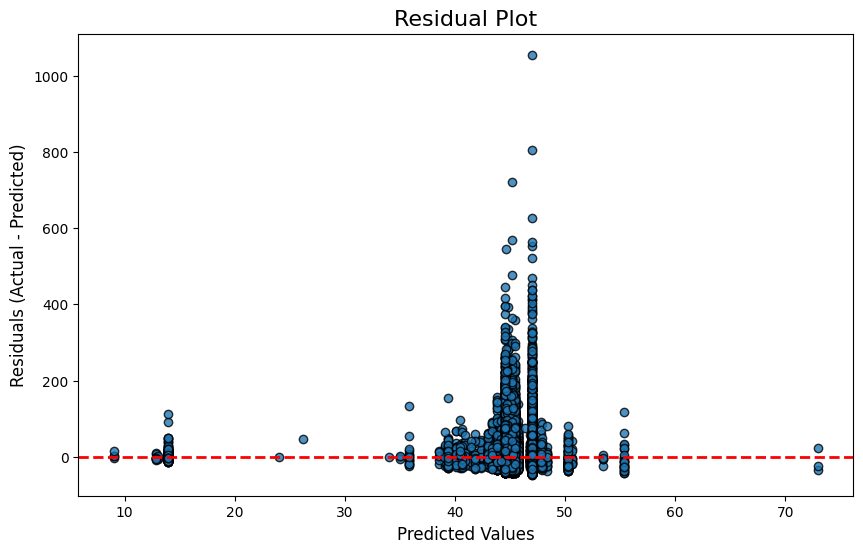

In [ ]:
#Getting unique labels
import matplotlib.pyplot as plt

plt_df = inference_result_sdf.select(F.col("PREDICTION"), F.col("RETURN_ROW_PRICE")).to_pandas()
y_predicted = plt_df['PREDICTION']
y_actual = plt_df['RETURN_ROW_PRICE']
# --- 1. Calculate Residuals ---
# You need y_actual and y_predicted from the previous example
residuals = y_actual - y_predicted

# --- 2. Create the Residual Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_predicted, residuals, edgecolors=(0, 0, 0), alpha=0.8)

# --- 3. Add a Horizontal Line at Zero ---
# This line represents zero error
ax.axhline(y=0, color='r', linestyle='--', lw=2)

# --- 4. Add Labels and Title ---
ax.set_xlabel('Predicted Values', fontsize=12)
ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax.set_title('Residual Plot', fontsize=16)

plt.show()

We can look at the query that contains our inference function.  It makes use of the SQL API for Model registry to call the inference function `MODEL_VERSION_ALIAS!PREDICT(RETURN_RATIO, FREQUENCY) AS TMP_RESULT`

In [ ]:

ind_sql = inference_result_sdf.queries['queries'][0]
ind_fmtd_sql = os.linesep.join(ind_sql.split(os.linesep)[:1000])
print(ind_fmtd_sql)

SELECT 
    "O_CUSTOMER_SK", 
    "ASOF_DATE", 
     CAST ("TMP_RESULT_CKYDUYKHCA"['RETURN_RATIO'] AS DOUBLE) AS "RETURN_RATIO", 
     CAST ("TMP_RESULT_CKYDUYKHCA"['FREQUENCY'] AS DOUBLE) AS "FREQUENCY", 
     CAST ("TMP_RESULT_CKYDUYKHCA"['RETURN_ROW_PRICE'] AS DOUBLE) AS "RETURN_ROW_PRICE", 
     CAST ("TMP_RESULT_CKYDUYKHCA"['PREDICTION'] AS FLOAT) AS "PREDICTION"
 FROM (
WITH SNOWPARK_ML_MODEL_INFERENCE_INPUT_N6YU98L9JE AS (SELECT
                                l_0.*,

                                r_0.* EXCLUDE (O_CUSTOMER_SK, LATEST_ORDER_DATE)
                            FROM (SELECT 
    "O_CUSTOMER_SK", 
    max("LATEST_ORDER_DATE") AS "ASOF_DATE"
 FROM (
SELECT 
    "O_CUSTOMER_SK", 
    "LATEST_ORDER_DATE", 
     CAST ("FREQUENCY" AS NUMBER(38, 3)) AS "FREQUENCY", 
     CAST ("RETURN_RATIO" AS NUMBER(38, 3)) AS "RETURN_RATIO", 
     CAST ("RETURN_ROW_PRICE" AS NUMBER(38, 3)) AS "RETURN_ROW_PRICE"
 FROM (
 SELECT  * 
 FROM (
(
 SELECT 
    "O_CUSTOMER_SK" AS "O_CUSTOMER_S

## CLEAN UP

In [ ]:
# session.close()

In [ ]:
from datetime import datetime
from zoneinfo import ZoneInfo
formatted_time = datetime.now(ZoneInfo("Australia/Melbourne")).strftime("%A, %B %d, %Y %I:%M:%S %p %Z")

print(f"The last run time in Melbourne is: {formatted_time}")

The last run time in Melbourne is: Wednesday, November 26, 2025 10:13:14 PM AEDT
